In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
BALANCE = ['balanced', 'unbalanced']
NETWORK = ['Same network sizes' , 'Different network sizes']
HOMOGENEITY = ['Homogeneous classes distribution', 'Heterogeneous classes distribution']

In [129]:
base_filename = "logs/mnist_test_10_nets_{}/experiment_log-0-1.log"

df = pd.DataFrame()
df_com = pd.DataFrame()

for jj, net in enumerate(["normal", "varying"]):
    for kk, homogeneity in enumerate(['homo', 'hetero']):
        for ii, balance in enumerate(['', '_change']):
            exp = net + '_' + homogeneity  + balance

            filename = base_filename.format(exp)
            epoch = 0
            current_network = 0
            with open(filename) as file:
                while line := file.readline():
                    line_str = line.rstrip()
                    words = line_str.split(' ')[6:]
                    if ">>" in line_str:
                        phase = words[1]
                        if phase == "Pre-Training":
                            mode = words[2]
                            acc = words[4]
                        else:
                            mode = phase
                            phase = "After Training"
                            acc = words[-1]

                        df = df.append(
                            pd.DataFrame(
                                {  
                                    "net" : [NETWORK[jj]],
                                    "homogeneity" : [HOMOGENEITY[kk]],
                                    "balance" :[BALANCE[ii]],
                                    "epoch" : [n_communication],
                                    "network" : [int(current_network)],
                                    "phase" : [phase],
                                    "mode" : [mode],
                                    "acc" : [float(acc)],
                                }, index = [0]
                            )
                        )
                    elif "Communication" in line_str:
                        n_communication = int(words[1][0])
                        train_acc = float(words[4][:-1])
                        test_acc = float(words[7][:-1])
                        shapes = ''
                        for i in range(9,15):
                            shapes += words[i]
                        shapes = shapes.replace('[', '').replace(']', '').replace('(', '').replace(')', '').split(',')
                        n_hidden_neurons = int(shapes[1])

                        df_com = df_com.append(
                            pd.DataFrame(
                                {   
                                    "net" : [NETWORK[jj]],
                                    "homogeneity" : [HOMOGENEITY[kk]],
                                    "balance" :[BALANCE[ii]],
                                    "mode" : ["PDM"],
                                    "epoch" : [n_communication],
                                    "Train accuracy" : [train_acc],
                                    "Test accuracy" : [test_acc],
                                    "n_hidden" : [n_hidden_neurons],
                                }, index = [0]
                            )
                        )
                    
                    elif "ensemble" in line_str and not("Experiment" in line_str):
                        type_acc = "Train" if "Train" in words[2] else "Test"
                        if type_acc == 'Train':
                            tracc = float(words[4])
                            
                        if type_acc ==  'Test':
                            teacc = float(words[4])
                            df_com = df_com.append(
                                pd.DataFrame(
                                    {   
                                        "net" : [NETWORK[jj]],
                                        "homogeneity" : [HOMOGENEITY[kk]],
                                        "balance" :[BALANCE[ii]],
                                        "mode" : ["Ensemble"],
                                        "epoch" : [0],
                                        "Train accuracy" : [tracc],
                                        "Test accuracy" : [teacc],
                                        "n_hidden" : [0],
                                    }, index = [0]
                                )
                            )
                        
                    elif "Training network" in line_str:
                        current_network = words[2]
df_com['type'] = df_com['net'] + ' & ' + df_com['homogeneity']

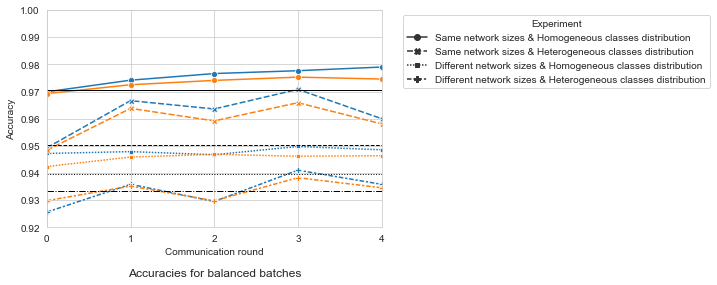

In [148]:
ii=0 # Balanced
sns.lineplot(data=df_com[(df_com.balance == BALANCE[ii]) & (df_com['mode'] =='PDM') ], y='Train accuracy',x='epoch', style='type', markers=True)
sns.lineplot(data=df_com[df_com.balance == BALANCE[ii]], y='Test accuracy',x='epoch', style='type', legend=False, markers=True)
for i, type_ in enumerate(df_com['type'].unique()):
    y = df_com.loc[(df_com.balance == BALANCE[ii]) & (df_com['mode'] =='Ensemble') & (df_com['type']==type_), 'Test accuracy'].iloc[0]
    plt.axhline(y=y, color='k', linestyle=['-', '--', ':', '-.'][i], linewidth=1.)
plt.legend(bbox_to_anchor=(1.05,1), title='Experiment')
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel("Communication round")
plt.ylabel("Accuracy")
plt.ylim((0.92,1.))
plt.xlim((0,4))
plt.title('Accuracies for balanced batches', y=-0.25)
plt.show()

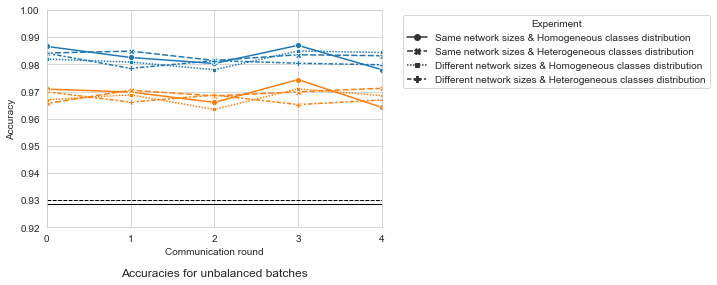

In [149]:
ii=1 # Unbalanced
sns.lineplot(data=df_com[(df_com.balance == BALANCE[ii]) & (df_com['mode'] =='PDM')], y='Train accuracy',x='epoch', style='type', markers=True)
sns.lineplot(data=df_com[(df_com.balance == BALANCE[ii]) & (df_com['mode'] =='PDM')], y='Test accuracy',x='epoch', style='type', legend=False,  markers=True)
for i, type_ in enumerate(df_com['type'].unique()):
    y = df_com.loc[(df_com.balance == BALANCE[ii]) & (df_com['mode'] =='Ensemble') & (df_com['type']==type_), 'Test accuracy'].iloc[0]
    plt.axhline(y=y, color='k', linestyle=['-', '--', ':', '-.'][i], linewidth=1.)
plt.legend(bbox_to_anchor=(1.05,1), title='Experiment')
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel("Communication round")
plt.ylabel("Accuracy")
plt.ylim((0.92,1.))
plt.xlim((0,4))
plt.title('Accuracies for unbalanced batches', y=-0.25)
plt.show()